16-QAM OFDM TDL-B100 Channel

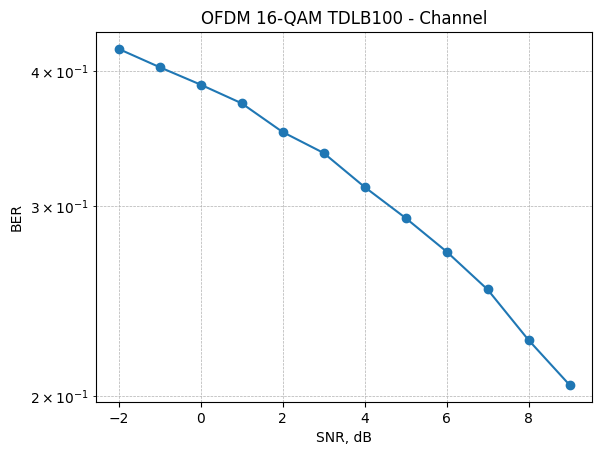

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def qam16_mod(x):
    """16-QAM Modulation"""
    x = x.reshape((-1, 4))  # Agrupa 4 bits
    # Definição da constelação 16-QAM
    mapping_table = {
        (0, 0, 0, 0): -3 - 3j,
        (0, 0, 0, 1): -3 - 1j,
        (0, 0, 1, 1): -3 + 1j,
        (0, 0, 1, 0): -3 + 3j,
        (0, 1, 0, 0): -1 - 3j,
        (0, 1, 0, 1): -1 - 1j,
        (0, 1, 1, 1): -1 + 1j,
        (0, 1, 1, 0): -1 + 3j,
        (1, 1, 0, 0): 1 - 3j,
        (1, 1, 0, 1): 1 - 1j,
        (1, 1, 1, 1): 1 + 1j,
        (1, 1, 1, 0): 1 + 3j,
        (1, 0, 0, 0): 3 - 3j,
        (1, 0, 0, 1): 3 - 1j,
        (1, 0, 1, 1): 3 + 1j,
        (1, 0, 1, 0): 3 + 3j
    }
    return np.array([mapping_table[tuple(bits)] for bits in x])

def qam16_demod(y):
    """16-QAM Demodulation"""
    demapping_table = {
        -3 - 3j: (0, 0, 0, 0),
        -3 - 1j: (0, 0, 0, 1),
        -3 + 1j: (0, 0, 1, 1),
        -3 + 3j: (0, 0, 1, 0),
        -1 - 3j: (0, 1, 0, 0),
        -1 - 1j: (0, 1, 0, 1),
        -1 + 1j: (0, 1, 1, 1),
        -1 + 3j: (0, 1, 1, 0),
         1 - 3j: (1, 1, 0, 0),
         1 - 1j: (1, 1, 0, 1),
         1 + 1j: (1, 1, 1, 1),
         1 + 3j: (1, 1, 1, 0),
         3 - 3j: (1, 0, 0, 0),
         3 - 1j: (1, 0, 0, 1),
         3 + 1j: (1, 0, 1, 1),
         3 + 3j: (1, 0, 1, 0)
    }
    demapped_bits = [demapping_table[min(demapping_table, key=lambda p: abs(y[i] - p))] for i in range(len(y))]
    return np.array(demapped_bits).flatten()

def idft_mat(M):
    """IDFT Matrix"""
    return np.array([[np.exp((2*1j*np.pi*n*k)/M)/M for n in range(M)] for k in range(M)])

def dft_mat(M):
    """DFT Matrix"""
    return np.array([[np.exp((-2*1j*np.pi*n*k)/M) for n in range(M)] for k in range(M)])

def cp_mat(D, M):
    """Prefixo cíclico"""
    zero_D = np.zeros((D, M-D))
    I_D = np.eye(D)
    I_M = np.eye(M)
    T_CP = np.vstack((np.hstack((zero_D, I_D)), I_M))
    return T_CP

def awgn(x: np.ndarray, snr_db: float, seed: int | None = None):
    """Adiciona ruído AWGN ao sinal"""
    rng = np.random.default_rng(seed=seed)
    Ps = np.vdot(x, x)/len(x)
    n = rng.standard_normal((len(x),)) + 1j*rng.standard_normal((len(x),))
    n *= np.sqrt(Ps*10**(-.1*snr_db)/(np.vdot(n, n)/len(n)))
    return x+n

def rm_cp_mat(D: int, M: int):
    """Remove o prefixo cíclico"""
    return np.hstack((np.zeros((M, D)), np.eye(M)))

def generate_multipath_channel(tap_delays, tap_powers, doppler_freq=0, seed=None):
    """
    Gera um canal multipercurso com atrasos, potências e Doppler.
    """
    rng = np.random.default_rng(seed)
    num_taps = len(tap_delays)
    tap_powers_linear = 10 ** (np.array(tap_powers) / 10)
    h_real = rng.normal(0, np.sqrt(tap_powers_linear / 2), size=num_taps)
    h_imag = rng.normal(0, np.sqrt(tap_powers_linear / 2), size=num_taps)
    h = h_real + 1j * h_imag
    return h

if __name__ == '__main__':
    snr_axis = np.arange(-2, 10, 1)
    BER = np.zeros((len(snr_axis),))
    rng = np.random.default_rng()
    M = 200
    N = 1000
    cp_len = 199
    ensemble = 10

    # Parâmetros do canal multipercurso
    tap_delays = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]  # Atrasos em ns
    tap_powers = [0, -1, -2, -4, -6, -8]  # Potências em dB

    for _ in range(ensemble):
        # Transmissor
        x = rng.integers(0, 2, (M * N * 4,))  # Gerando 4 bits por símbolo
        x_bar = qam16_mod(x)                  # Modulação 16-QAM
        X_bar = x_bar.reshape((M, N))
        X_tah = idft_mat(M) @ X_bar
        X_tah = cp_mat(cp_len, M) @ X_tah
        x_t = X_tah.T.flatten()
        
        # Canal
        h = generate_multipath_channel(tap_delays, tap_powers, seed=42)
        y_t = np.convolve(x_t, h, 'same')
        
        for idx, snr in np.ndenumerate(snr_axis):
            r = awgn(y_t, snr)
            # Receptor
            Y_cp = r.reshape((N, M + cp_len)).T
            Y_no_cp = rm_cp_mat(cp_len, M) @ Y_cp
            X_est = dft_mat(M) @ Y_no_cp
            pilot_in = X_bar[:, 0]
            pilot_out = X_est[:, 0]
            h_est = pilot_out / pilot_in
            W = np.diag(1 / h_est)
            X_real_est = W @ X_est
            X_final = qam16_demod(X_real_est.flatten())  # Demodulação QAM-16
            BER[idx] += np.mean(np.abs(X_final - x)) / ensemble

    # Plotando o gráfico BER x SNR
    figura = plt.figure()
    eixo = figura.add_subplot(1, 1, 1)
    eixo.plot(snr_axis, BER, "-o")
    eixo.set_yscale("log")
    eixo.set_xlabel('SNR, dB')
    eixo.set_ylabel('BER')
    plt.grid(True, which = "both", linestyle = "--", linewidth = 0.5)
    eixo.set_title('OFDM 16-QAM TDLB100 - Channel')
    plt.show()



QAM - 16 OFDM with AWGN Channel

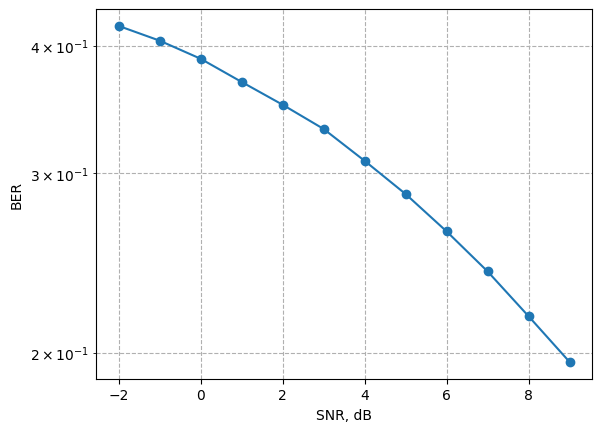

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def qam16_mod(x):
    """16-QAM Modulation"""
    x = x.reshape((-1, 4))  # Agrupa 4 bits
    # Definição da constelação 16-QAM
    mapping_table = {
        (0, 0, 0, 0): -3 - 3j,
        (0, 0, 0, 1): -3 - 1j,
        (0, 0, 1, 1): -3 + 1j,
        (0, 0, 1, 0): -3 + 3j,
        (0, 1, 0, 0): -1 - 3j,
        (0, 1, 0, 1): -1 - 1j,
        (0, 1, 1, 1): -1 + 1j,
        (0, 1, 1, 0): -1 + 3j,
        (1, 1, 0, 0): 1 - 3j,
        (1, 1, 0, 1): 1 - 1j,
        (1, 1, 1, 1): 1 + 1j,
        (1, 1, 1, 0): 1 + 3j,
        (1, 0, 0, 0): 3 - 3j,
        (1, 0, 0, 1): 3 - 1j,
        (1, 0, 1, 1): 3 + 1j,
        (1, 0, 1, 0): 3 + 3j
    }
    return np.array([mapping_table[tuple(bits)] for bits in x])

def qam16_demod(y):
    """16-QAM Demodulation"""
    # Definição da constelação 16-QAM
    demapping_table = {
        -3 - 3j: (0, 0, 0, 0),
        -3 - 1j: (0, 0, 0, 1),
        -3 + 1j: (0, 0, 1, 1),
        -3 + 3j: (0, 0, 1, 0),
        -1 - 3j: (0, 1, 0, 0),
        -1 - 1j: (0, 1, 0, 1),
        -1 + 1j: (0, 1, 1, 1),
        -1 + 3j: (0, 1, 1, 0),
         1 - 3j: (1, 1, 0, 0),
         1 - 1j: (1, 1, 0, 1),
         1 + 1j: (1, 1, 1, 1),
         1 + 3j: (1, 1, 1, 0),
         3 - 3j: (1, 0, 0, 0),
         3 - 1j: (1, 0, 0, 1),
         3 + 1j: (1, 0, 1, 1),
         3 + 3j: (1, 0, 1, 0)
    }
    demapped_bits = [demapping_table[min(demapping_table, key=lambda p: abs(y[i] - p))] for i in range(len(y))]
    return np.array(demapped_bits).flatten()

def idft_mat(M):
    """IDFT Matrix"""
    return np.array([[np.exp((2*1j*np.pi*n*k)/M)/M for n in range(M)] for k in range(M)])

def dft_mat(M):
    """DFT Matrix"""
    return np.array([[np.exp((-2*1j*np.pi*n*k)/M) for n in range(M)] for k in range(M)])

def cp_mat(D, M):
    """Prefixo cíclico"""
    zero_D = np.zeros((D, M-D))
    I_D = np.eye(D)
    I_M = np.eye(M)
    T_CP = np.vstack((np.hstack((zero_D, I_D)), I_M))
    return T_CP

def awgn(x: np.ndarray, snr_db: float, seed: int | None = None):
    """Adiciona ruído AWGN ao sinal"""
    rng = np.random.default_rng(seed=seed)
    Ps = np.vdot(x, x)/len(x)
    n = rng.standard_normal((len(x),)) + 1j*rng.standard_normal((len(x),))
    n *= np.sqrt(Ps*10**(-.1*snr_db)/(np.vdot(n, n)/len(n)))
    return x+n

def rm_cp_mat(D: int , M: int):
    """Remove o prefixo cíclico"""
    return np.hstack((np.zeros((M, D)), np.eye(M)))

if __name__ == '__main__':
    snr_axis = np.arange(-2, 10, 1)
    BER = np.zeros((len(snr_axis),))
    rng = np.random.default_rng()
    K = 50000  # Número de bits
    M = 200    # Número de subportadoras
    N = 1000   # Número de símbolos OFDM
    cp_len = 199
    ensemble = 25
    h = [.2816, .5622, .2677, 0.3260, -0.4451, 0.0415, 0.3102, 0.0292, -0.2992, -0.2004]
    
    for _ in range(ensemble):
        # Transmissor
        x = rng.integers(0, 2, (M * N * 4,))  # Gerando bits compatíveis com M e N
        x_bar = qam16_mod(x)              # Modulação 16-QAM
        X_bar = x_bar.reshape((M, N))
        X_tah = idft_mat(M) @ X_bar
        X_tah = cp_mat(cp_len, M) @ X_tah
        x_t = X_tah.T.flatten()
        # Canal
        y_t = np.convolve(x_t, h, 'same')
        for idx, snr in np.ndenumerate(snr_axis):
            r = awgn(y_t, snr)
            # Receptor
            Y_cp = r.reshape((N, M+cp_len)).T
            Y_no_cp = rm_cp_mat(cp_len, M) @ Y_cp
            X_est = dft_mat(M) @ Y_no_cp
            pilot_in = X_bar[:, 0]
            pilot_out = X_est[:, 0]
            h_est = pilot_out/pilot_in
            W = np.diag(1/h_est)
            X_real_est = W @ X_est
            X_final = qam16_demod(X_real_est.flatten())  # Demodulação QAM-16
            BER[idx] += np.mean(np.abs(X_final - x))/ensemble
    figura = plt.figure()
    eixo = figura.add_subplot(1, 1, 1)
    eixo.plot(snr_axis, BER, "-o")
    eixo.set_yscale("log")
    eixo.set_xlabel('SNR, dB')
    eixo.set_ylabel('BER')
    plt.grid(True, which="both", linestyle="--")
    plt.show()
    


BPSK OFDM with AWGN Channel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def bpsk_mod(x):
    """BPSK mod"""
    x = 2*x
    x -= 1

    return x


def idft_mat(M):
    """"""
    return np.array([[np.exp((2*1j*np.pi*n*k)/M)/M for n in range(M)] for k in range(M)])


def dft_mat(M):
    """"""
    return np.array([[np.exp((-2*1j*np.pi*n*k)/M) for n in range(M)] for k in range(M)])


def cp_mat(D, M):
    """"""
    zero_D = np.zeros((D, M-D))
    I_D = np.eye(D)
    I_M = np.eye(M)

    T_CP = np.vstack((np.hstack((zero_D, I_D)), I_M))

    return T_CP


def awgn(x: np.ndarray, snr_db: float, seed: int | None = None):
    """"""
    rng = np.random.default_rng(seed=seed)
    Ps = np.vdot(x, x)/len(x)
    n = rng.standard_normal((len(x),)) + 1j*rng.standard_normal((len(x),))
    n *= np.sqrt(Ps*10**(-.1*snr_db)/(np.vdot(n, n)/len(n)))

    return x+n


def rm_cp_mat(D: int , M: int):
    """"""
    return np.hstack((np.zeros((M, D)), np.eye(M)))


if __name__ == '__main__':
    snr_axis = np.arange(-2,10, 1)
    BER = np.zeros((len(snr_axis),))
    rng = np.random.default_rng()
    K = 200000
    M = 200
    N = 1000
    cp_len = 32
    ensemble = 10
    h = [.2816, .5622, .2677, 0.3260, -0.4451, 0.0415, 0.3102, 0.0292, -0.2992, -0.2004]
    
    for _ in range(ensemble):
        # Transmitter
        x = rng.integers(0, 2, (K,)).astype(np.complex128)
        x_bar = bpsk_mod(x)
        X_bar = x_bar.reshape((M, N))
        X_tah = idft_mat(M) @ X_bar
        X_tah = cp_mat(cp_len, M) @ X_tah
        x_t = X_tah.T.flatten()
        # Channel
        y_t = np.convolve(x_t, h, 'same')
        for idx, snr in  np.ndenumerate(snr_axis):
            r = awgn(y_t, snr)
            # Reception
            Y_cp = r.reshape((N, M+cp_len)).T
            Y_no_cp = rm_cp_mat(cp_len, M) @ Y_cp
            X_est = dft_mat(M) @ Y_no_cp
            pilot_in = X_bar[:, 0]
            pilot_out = X_est[:, 0]
            h_est = pilot_out/pilot_in
            W = np.diag(1/h_est)
            X_real_est = W @ X_est
            X_final = X_real_est.flatten()
            for i, value in np.ndenumerate(X_final):
                if value > 0:
                    X_final[i] = 1
                else:
                    X_final[i] = 0
            BER[idx] += np.mean(np.abs(X_final - x))/ensemble
    figura = plt.figure()
    eixo = figura.add_subplot(1, 1, 1)
    eixo.plot(snr_axis, BER, "-o")
    eixo.set_yscale("log")
    eixo.set_xlabel('SNR, dB')
    eixo.set_ylabel('BER')
    plt.show()
    eixo.set_title('OFDM - BPSK - AWGN Channel')